In [1]:
# from https://github.com/linnykos/veloUncertainty/blob/main/code/erythroid/replicate_coherence/seed317/other/v4_ery_countsplit_gp_317.py
# 
# # scvelo virtual environment

import scvelo as scv
import numpy as np
import scanpy as sc
import math
import matplotlib.pyplot as plt
import scipy.io
import anndata as ad
import pandas as pd
import datetime


In [2]:
import sys
sys.path.append('/home/users/kzlin/kzlinlab/projects/veloUncertainty/git/veloUncertainty_kevin/veloUncertainty')
from countsplit import *
from v4_functions import print_message_with_time

In [3]:
data_folder = '/home/users/kzlin/kzlinlab/projects/veloUncertainty/out/kevin/simulation/'

adata = ad.read_h5ad(data_folder + 'adata.h5ad') 
adata

AnnData object with n_obs × n_vars = 1000 × 20
    obs: 'true_t', 'n_counts', 'true_velocity_self_transition', 'velocity_self_transition'
    var: 'true_t_', 'true_alpha', 'true_beta', 'true_gamma', 'true_scaling', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2'
    uns: 'neighbors', 'pca', 'recover_dynamics', 'true_velocity_graph', 'true_velocity_graph_neg', 'true_velocity_params', 'velocity_graph', 'velocity_graph_neg', 'velocity_params'
    obsm: 'X_pca', 'true_velocity_pca', 'velocity_pca'
    varm: 'PCs', 'loss'
    layers: 'Ms', 'Mu', 'fit_t', 'fit_tau', 'fit_tau_', 'spliced', 'spliced_raw', 'true_velocity', 'unspliced', 'unspliced_raw', 'variance_velocity', 'velocity'
    obsp: 'connectivities', 'distances'

# Run scVelo dynamical

recovering dynamics (using 1/20 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:00:04) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/20 cores)
    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)


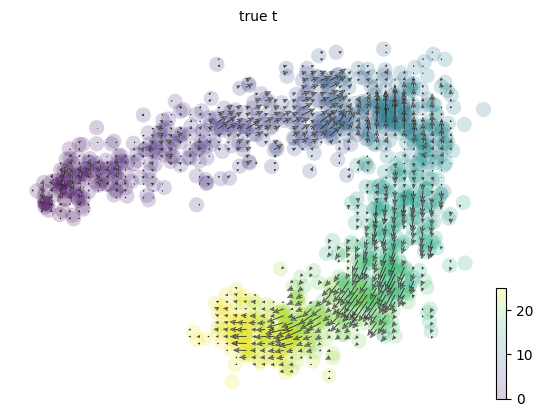

In [4]:
scv.tl.recover_dynamics(adata)
scv.tl.velocity(adata, mode='dynamical')
scv.tl.velocity_graph(adata)
scv.pl.velocity_embedding_grid(adata,
                               basis='pca',
                               color="true_t",
                               vkey="velocity",
                               arrow_length=2,
                               arrow_size=2,
                               min_mass=10)

In [5]:
def compute_velocity_cosine_similarity(v1, v2, plot=True, title=None, ax=None):
    """
    Computes row-wise cosine similarity between two velocity matrices.

    Parameters:
    -----------
    v1, v2 : np.ndarray
        The two velocity matrices to compare (must be same shape, e.g., n_cells x n_genes).
    plot : bool
        Whether to generate the histogram plot.
    title : str, optional
        Custom title for the plot.
    ax : matplotlib.axes.Axes, optional
        Existing axes to draw the plot onto. If None, creates a new figure.

    Returns:
    --------
    cosine_sims : np.ndarray
        Vector of cosine similarities per cell.
    """
    
    # Ensure inputs are numpy arrays (in case they are passed as other formats)
    v1 = np.array(v1)
    v2 = np.array(v2)
    
    # Safety check
    if v1.shape != v2.shape:
        raise ValueError(f"Shape mismatch: v1 is {v1.shape} but v2 is {v2.shape}")

    # --- Compute Cosine Similarity ---
    # Dot product per cell
    dot_product = np.sum(v1 * v2, axis=1)

    # Magnitudes (L2 norm)
    norm1 = np.linalg.norm(v1, axis=1)
    norm2 = np.linalg.norm(v2, axis=1)

    # Calculate similarity with epsilon safety
    epsilon = 1e-8
    cosine_sims = dot_product / (norm1 * norm2 + epsilon)

    # --- Plotting ---
    if plot:
        mean_sim = np.mean(cosine_sims)
        median_sim = np.median(cosine_sims)
        
        # If no axis is provided, create a new figure
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 5))
            
        ax.hist(cosine_sims, bins=30, color='skyblue', edgecolor='black', alpha=0.7)

        # Add vertical lines
        ax.axvline(mean_sim, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_sim:.2f}')
        ax.axvline(median_sim, color='green', linestyle=':', linewidth=3, label=f'Median: {median_sim:.2f}')

        # Labels
        final_title = title if title else 'Cosine Similarity Distribution'
        ax.set_title(final_title)
        ax.set_xlabel('Cosine Similarity')
        ax.set_ylabel('Number of Cells')
        ax.legend()
        ax.grid(axis='y', alpha=0.3)
        
        if ax is None:
            plt.tight_layout()
            plt.show()

    return cosine_sims

In [6]:
adata

AnnData object with n_obs × n_vars = 1000 × 20
    obs: 'true_t', 'n_counts', 'true_velocity_self_transition', 'velocity_self_transition'
    var: 'true_t_', 'true_alpha', 'true_beta', 'true_gamma', 'true_scaling', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'neighbors', 'pca', 'recover_dynamics', 'true_velocity_graph', 'true_velocity_graph_neg', 'true_velocity_params', 'velocity_graph', 'velocity_graph_neg', 'velocity_params'
    obsm: 'X_pca', 'true_velocity_pca', 'velocity_pca'
    varm: 'PCs', 'loss'
    layers: 'Ms', 'Mu', 'fit_t', 'fit_tau', 'fit_tau_', 'spliced', 'spliced_raw', 'true_velocity', 'unspliced', 'unspliced_raw', 'variance_velocity', 'velocity', 'velocity_u'
    obsp: 'connectivities', 'distances'

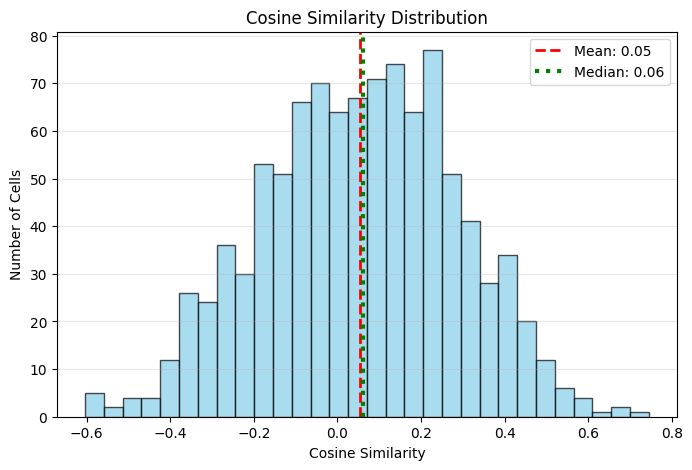

In [7]:
v_true = adata.layers['true_velocity']
v_total = adata.layers['velocity']
_ = compute_velocity_cosine_similarity(v_true, v_total)


# Splitting

In [8]:
def run_countsplit_with_overdispersion(S,U,split_seed,overdisp_S,overdisp_U):
    print_message_with_time("########### Countsplitting")
    np.random.seed(split_seed)
    s1, s2  = countsplit(S,overdisps=overdisp_S)
    u1, u2  = countsplit(U,overdisps=overdisp_U)
    return [[s1,u1],[s2,u2]]

def create_adata(S_split,U_split,adata_total):
    adata_split = ad.AnnData(X=S_split.astype(np.float32))
    adata_split.layers["spliced"] = S_split
    adata_split.layers["unspliced"] = U_split
    adata_split.obs = pd.DataFrame(index=adata_total.obs.index)
    for obs_col in adata_total.obs.columns:
        adata_split.obs[obs_col] = adata_total.obs[obs_col].copy()
    adata_split.var = pd.DataFrame(index=adata_total.var.index)
    for var_col in adata_total.var.columns:
        adata_split.var[var_col] = adata_total.var[var_col].copy()
    adata_split.layers['true_velocity'] = adata_total.layers['true_velocity'].copy()
    adata_split.layers['total_velocity'] = adata_total.layers['velocity'].copy()
    
    sc.pp.pca(adata_split)
    sc.pp.neighbors(adata_split, n_pcs=30, n_neighbors=30)
    scv.pp.moments(adata_split, n_pcs=None, n_neighbors=None)
    return adata_split

def countsplit_and_create_adata(S,U,total,split_seed,overdisp_S,overdisp_U):
    print_message_with_time("########### Running the function for overdispersion estimation and countsplitting")
    split1,split2 = run_countsplit_with_overdispersion(S=S,U=U,split_seed=split_seed,overdisp_S=overdisp_S,overdisp_U=overdisp_U)
    print_message_with_time("########### Creating split adata objects")
    adata1 = create_adata(split1[0],split1[1],total)
    adata2 = create_adata(split2[0],split2[1],total)
    return adata1,adata2

In [9]:
print_message_with_time("########### Reading data")
overdisp_S = np.array(pd.read_csv(data_folder+'overdisp_S.csv')['x'])
overdisp_U = np.array(pd.read_csv(data_folder+'overdisp_U.csv')['x'])

S_mat = adata.layers['spliced'].copy()
U_mat = adata.layers['unspliced'].copy()

########### Reading data at 2025-12-13 14:14:50


In [10]:
split_seed = 12122025
print_message_with_time("########### Starting countsplit")
adata_split1,adata_split2 = countsplit_and_create_adata(S=S_mat,U=U_mat,total=adata,split_seed=split_seed,overdisp_S=overdisp_S,overdisp_U=overdisp_U)

########### Starting countsplit at 2025-12-13 14:14:56
########### Running the function for overdispersion estimation and countsplitting at 2025-12-13 14:14:56
########### Countsplitting at 2025-12-13 14:14:56
########### Creating split adata objects at 2025-12-13 14:14:57
Normalized count data: X, spliced, unspliced.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
Normalized count data: X, spliced, unspliced.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


# Splits 1 and 2

recovering dynamics (using 1/20 cores)
    finished (0:00:04) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/20 cores)
    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)


/home/users/kzlin/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])


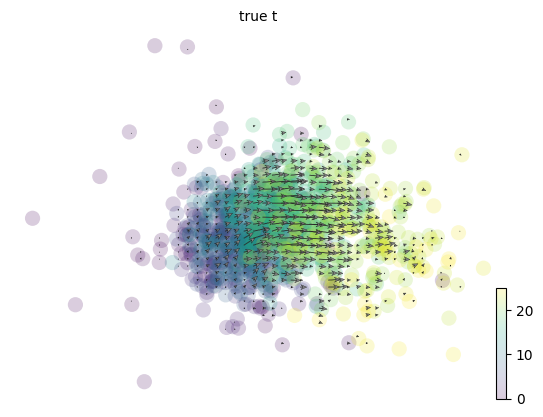

In [11]:
scv.tl.recover_dynamics(adata_split1)
scv.tl.velocity(adata_split1, mode='dynamical')
scv.tl.velocity_graph(adata_split1)
scv.pl.velocity_embedding_grid(adata_split1,
                               basis='pca',
                               color="true_t",
                               vkey="velocity",
                               arrow_length=2,
                               arrow_size=2,
                               min_mass=10)

recovering dynamics (using 1/20 cores)
    finished (0:00:04) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/20 cores)
    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)


/home/users/kzlin/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])


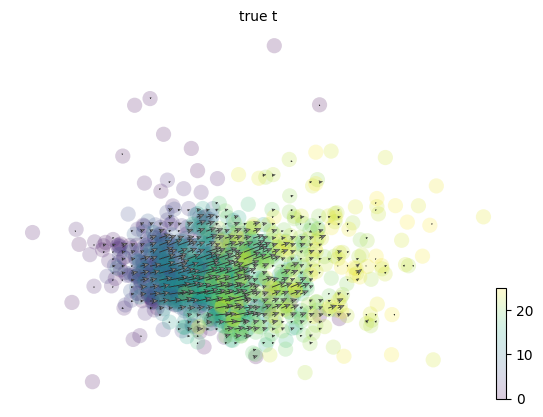

In [12]:
scv.tl.recover_dynamics(adata_split2)
scv.tl.velocity(adata_split2, mode='dynamical')
scv.tl.velocity_graph(adata_split2)
scv.pl.velocity_embedding_grid(adata_split2,
                               basis='pca',
                               color="true_t",
                               vkey="velocity",
                               arrow_length=2,
                               arrow_size=2,
                               min_mass=10)

# Replicate coherence

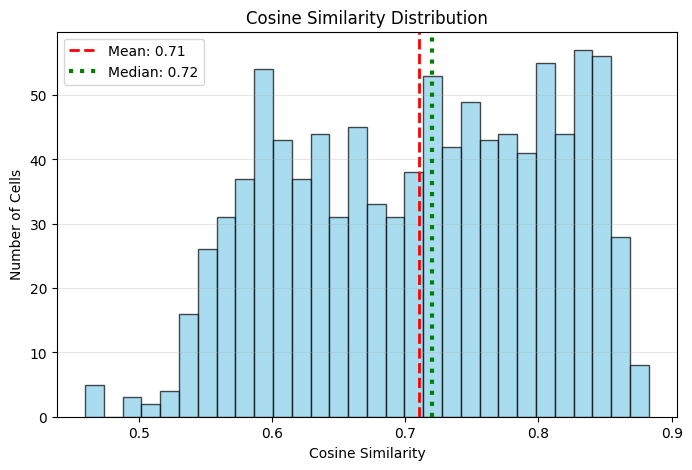

In [13]:
v_split1 = adata_split1.layers['velocity']
v_split2 = adata_split2.layers['velocity']
_ = compute_velocity_cosine_similarity(v_split1, v_split2)
